In [59]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

import pennylane as qml
import tensorflow as tf
import numpy as np

import keras_metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.utils import shuffle

In [60]:
qml.enable_tape()
mpl.rcParams['figure.dpi'] = 100
tf.keras.backend.set_floatx('float64')

# Нейронные сети

Нейронные сети состоят из нейронов -- пороговых логических элементов.

<img src="https://upload.wikimedia.org/wikipedia/ru/b/ba/Single_layer_perceptron.png" width=30%>

Нейроны объединены в слои. Слои объединяются в нейросеть. Пример -- линейный перцептрон.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Perceptron-ru.svg/1024px-Perceptron-ru.svg.png" width=50%>

# Гибридные нейронные сети. Quantum transfer learning
Так как существуют параметризованные квантовые схемы, и они линейны, то можно представить их как один или несколько слоев нейронных сетей и использовать их для классификации данных. Такой подход называется **circuit-centric quantum classifiers**. Его можно представить в виде схемы, на которой с использованием разных формальных языков описаны этапы работы алгоритма.

<img src="circuit-centric.png" width=50% height=50%>

Если мы можем построить классификатор на основе квантовой схемы, то мы  его можем внедрить в существующую нейронную сеть как её часть. В **pennylane** можно безшовно интегрировать параметризованные квантовые схемы в нейронные сети, построенные в **Keras** и **PyTorch**. Цель -- ускорение решения задач высокой размерности (если есть неограниченный доступ к квантовому компьютеру).

Quantum transfer learning -- это гибридная концепция построения самообучающихся систем, где часть системы является классической, а часть -- выполняется на квантовом компьютере.

<img src="https://pennylane.ai/qml/_images/transfer_learning_general.png" width=50% height=50%>

Пример реализации Quantum transfer learning:  https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html

Для тестирования этого подхода построим гибридную нейронную сеть для работы с сетом **iris**, который доступен в **sklearn.datasets**. Это уже подготовленный классифицированный сет признаков для рисунков ирисов. Всего есть 4 признака и 3 класса (вида цветка) **'setosa', 'versicolor', 'virginica'** или **'щетинистый', 'разноцветный', 'виргинский'**. Им сопоставлены числа 0, 1 и 2. Загрузим сет и подготовим его для обучения.

In [61]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data
Y = iris.target

# Сколько элементов исключать из обучающих данных для финального тестирования
exclude_items = 10

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
if exclude_items:
    X_exclude = X_train[:exclude_items]
    y_exclude = y_train[:exclude_items]
    X_train = X_train[exclude_items:]
    y_train = y_train[exclude_items:]

print(f'Train set: {len(X_train)} items, test set: {len(X_test)} items, exclude {exclude_items} items')

Train set: 95 items, test set: 45 items, exclude 10 items


In [62]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

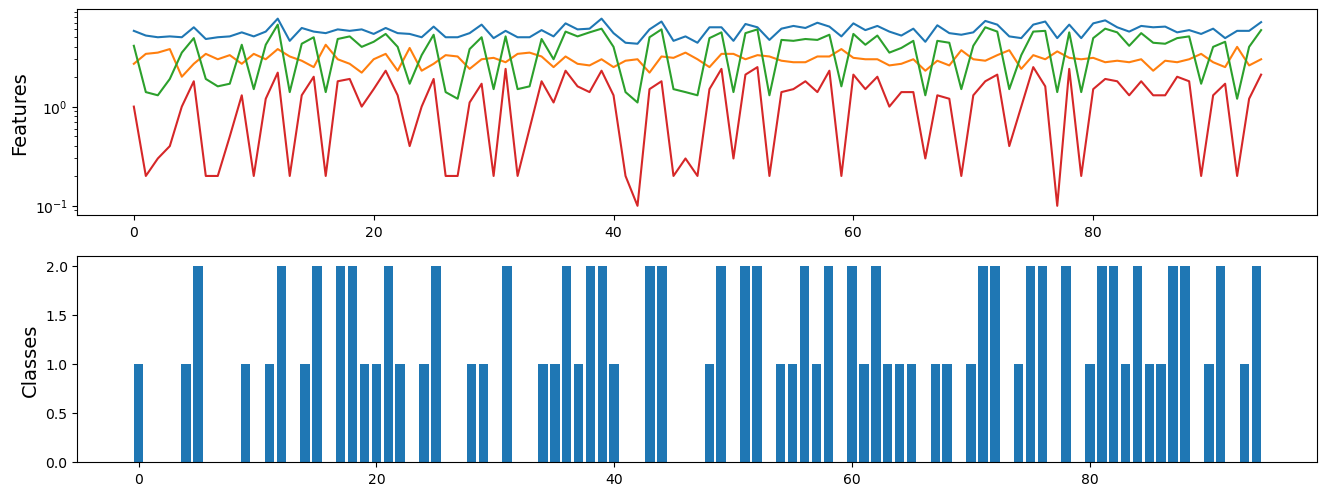

In [63]:
fig = plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(X_train)
plt.yscale('log')
plt.ylabel('Features', fontsize=14)
plt.subplot(212)
plt.bar(range(len(y_train)), y_train)
plt.ylabel('Classes', fontsize=14)
plt.show()

Преобразуем информацию о классах обучающего и тестового сетов в векторный вид: $0\to\{1,0,0\},1\to\{0,1,0\},2\to\{0,0,1\}$

In [64]:
y_train = tf.one_hot(y_train, depth=3)
y_test = tf.one_hot(y_test, depth=3)

Создадим простейшую модуль для обучения. В ней на входе и выходе расположены однослойные перцептроны (слои, в которых каждый нейрон связян со всеми входами), а посередине квантовый слой (схема), которые состоят из слоя амплитудного представления данных и один или несколько квантовых слоев **strongly entangling layers** (https://arxiv.org/pdf/1804.00633.pdf).

**Strongly entangling layer** -- это квантовый классификатор, построенный из простых соображений: необходима схема, классифицирующая данные по классам, сложность которой растет полиномиально, и в которой используются только одно- и двухкубитные гейты. 

<img src="https://pennylane.readthedocs.io/en/stable/_images/layer_sec.png">

Как такая схема классифицирует данные? По сути -- это некоторое унитарное преобразование, переводящее один кет-вектор (полученный из данных с помощью QFM) в другой. И последний должен обладать следующим свойством: если мы берем некоторые результаты измерений $R_1,\dots,R_n$, то они должны кластеризоваться по классам. Простейший пример. Если у нас есть два класса $\{0,1\}$, то на выходе нам интересна сумма $S=\sum_k R_k + b$. Если $S> 0.5$, то класс данных 1, если меньше, то 0. Если классов больше, то может быть меньше интервал допустимых значений для отдельного класса.

В чем плюс такой схемы? В сложности и числе параметров. За счет "сжатия" данных при их квантовом представлении, идет уменьшение размерности задачи $N\to\log_2N$ и снижается число необходимых параметров до $3\log_2 N$.

Будем оптимизировать параметры модели для достижения минимальной перекрестной энтропии $H(p, q)$ между векторами классов $p$ и их оценками $q$:

$$ H(p, q) = - \sum_k p_k \log q_k $$

При этом исходные вектора и их оценки должны быть как можно ближе, то есть классы должны определяться однозначно и верно.

В Keras есть много разных функций потерь, см. https://keras.io/api/losses/

In [80]:
n_qubits = 2
layers = 1
data_dimension = 3
dev = qml.device("default.qubit.tf", wires=n_qubits)

@qml.qnode(dev, interface='tf')
def qlayer(weights, inputs=None):
    # Генерация strongly entangling layers после амплитудного представления данных
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=True, pad_with=0)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Размерность весов для квантового слоя
weight_shapes = {"weights": (layers, n_qubits, 3)}

# Создаем модель
model = tf.keras.models.Sequential()
# Первый плотный слой размерности 2 ** n_qubits с числом входов, равным размерности данных
model.add(tf.keras.layers.Dense(
    2 ** n_qubits, activation='relu', input_dim=len(X_train[0]), trainable=False))
# Квантовый слой в обертке для интеграции с Keras
model.add(qml.qnn.KerasLayer(qlayer, weight_shapes, output_dim=n_qubits))
# Преобраующий слой. Конвертирует квантовые данные размерности n_qubits в классические размерности data_dimension
model.add(tf.keras.layers.Dense(data_dimension, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.016)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [66]:
def print_state(dev):
    return ' + '.join(map(lambda x: f'({x[0].real:.2f} + {x[0].imag:.2f}i)' + x[1], 
                     zip(dev.state.numpy(), ['|00>', '|01>', '|10>', '|11>'])))

In [81]:
qlayer(np.random.randint(2, size=layers * n_qubits * 3).reshape(weight_shapes["weights"]), X_train[0])
print(qlayer.draw())
print(print_state(dev))

 0: ──╭QubitStateVector(M0)──Rot(1, 1, 1)──╭C──╭X──┤ ⟨Z⟩ 
 1: ──╰QubitStateVector(M0)──Rot(0, 0, 0)──╰X──╰C──┤ ⟨Z⟩ 
M0 =
[0.75676497 0.35228714 0.53495455 0.13047672]

(0.10 + -0.56i)|00> + (0.62 + 0.40i)|01> + (0.23 + 0.10i)|10> + (0.10 + -0.26i)|11>


Информация о слоях и параметрах модели

In [82]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=2, verbose=0)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
keras_layer_4 (KerasLayer)   (None, 2)                 6         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 9         
Total params: 35
Trainable params: 15
Non-trainable params: 20
_________________________________________________________________


График значений $\langle Z_1\rangle$ и $\langle Z_2\rangle$ на выходе квантового слоя после 1 эпохи после генерации сети

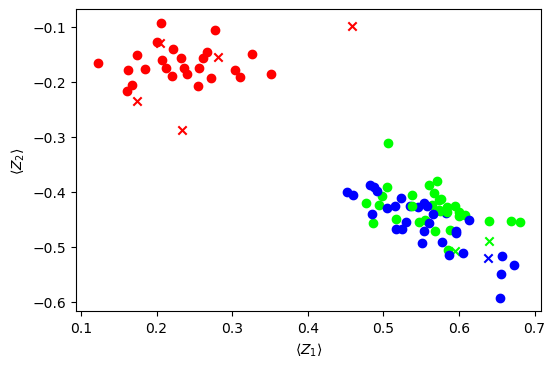

In [83]:
opt_weights = model.weights[2].numpy()
predictions = model.predict(X_train)

for x, y, p in zip(X_train, y_train, predictions):
    mk = 'o' if np.argmax(p) == np.argmax(y) else 'x'
    plt.scatter(*qlayer(opt_weights, inputs=x), color=y.numpy(), marker=mk)
plt.xlabel(r'$\langle Z_1\rangle$')
plt.ylabel(r'$\langle Z_2\rangle$')
plt.show()

Обучаем модель

In [90]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8, verbose=1)

Epoch 1/20
12/12 [==============================] - 2s 169ms/step - loss: 0.6700 - accuracy: 0.6632 - val_loss: 0.6281 - val_accuracy: 0.7111
Epoch 2/20
12/12 [==============================] - 2s 167ms/step - loss: 0.6682 - accuracy: 0.6526 - val_loss: 0.6127 - val_accuracy: 0.7111
Epoch 3/20
12/12 [==============================] - 2s 167ms/step - loss: 0.6613 - accuracy: 0.6737 - val_loss: 0.6005 - val_accuracy: 0.7778
Epoch 4/20
12/12 [==============================] - 2s 165ms/step - loss: 0.6568 - accuracy: 0.7895 - val_loss: 0.5979 - val_accuracy: 0.9333
Epoch 5/20
12/12 [==============================] - 2s 167ms/step - loss: 0.6543 - accuracy: 0.9158 - val_loss: 0.5953 - val_accuracy: 0.9556
Epoch 6/20
12/12 [==============================] - 2s 165ms/step - loss: 0.6524 - accuracy: 0.9053 - val_loss: 0.5963 - val_accuracy: 0.8889
Epoch 7/20
12/12 [==============================] - 2s 167ms/step - loss: 0.6490 - accuracy: 0.8632 - val_loss: 0.5919 - val_accuracy: 0.9333
Epoch 

Как меняется функция ошибки и точность

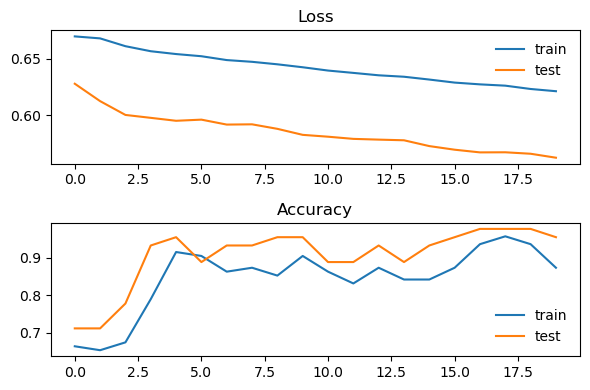

In [91]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(frameon=False)

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

График значений $\langle Z_1\rangle$ и $\langle Z_2\rangle$ на выходе квантового слоя после 31 эпохи после генерации сети

2 1 [0.12937903 0.43318445 0.43743652]
2 1 [0.08657655 0.42723779 0.48618566]


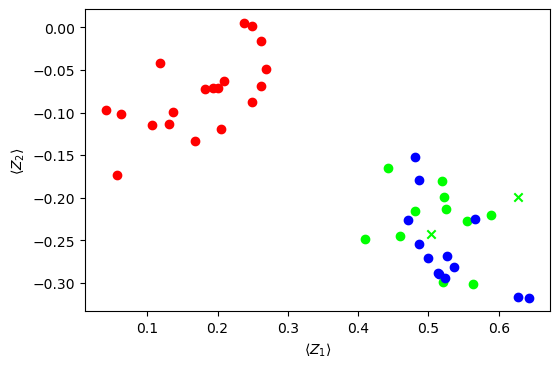

In [92]:
opt_weights = model.weights[2].numpy()
predictions = model.predict(X_test)

for x, y, p in zip(X_test, y_test, predictions):
    mk = 'o' if np.argmax(p) == np.argmax(y) else 'x'
    if np.argmax(p) != np.argmax(y):
        print(np.argmax(p), np.argmax(y), p)
    plt.scatter(*qlayer(opt_weights, inputs=x), color=y.numpy(), marker=mk)
plt.xlabel(r'$\langle Z_1\rangle$')
plt.ylabel(r'$\langle Z_2\rangle$')
plt.show()

График суммы значений $\langle Z_1\rangle$ и $\langle Z_2\rangle$ на выходе квантового слоя после 31 эпохи после генерации сети

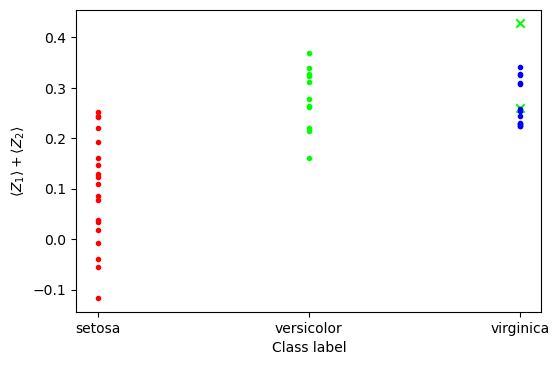

2 errors


In [93]:
opt_weights = model.weights[2].numpy()
predictions = model.predict(X_test)
err_counter = 0

for x, y, p in zip(X_test, y_test, predictions):
    if np.argmax(p) == np.argmax(y):
        mk = '.'
    else:
        err_counter += 1
        mk = 'x'
    plt.scatter(np.argmax(p), sum(qlayer(opt_weights, inputs=x)), color=y.numpy(), marker=mk)
plt.ylabel(r'$\langle Z_1\rangle + \langle Z_2\rangle$')
plt.xlabel('Class label')
plt.xticks([0,1,2], ['setosa', 'versicolor', 'virginica'])
plt.show()
print(f'{err_counter} errors')

In [94]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_exclude)
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (10, 3)


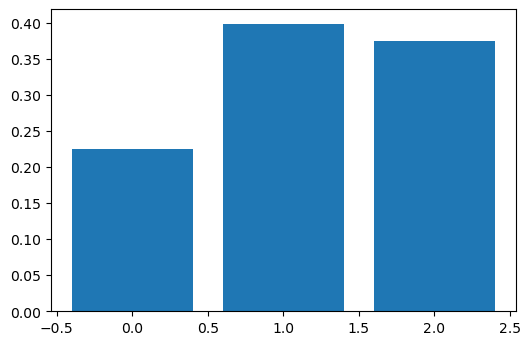

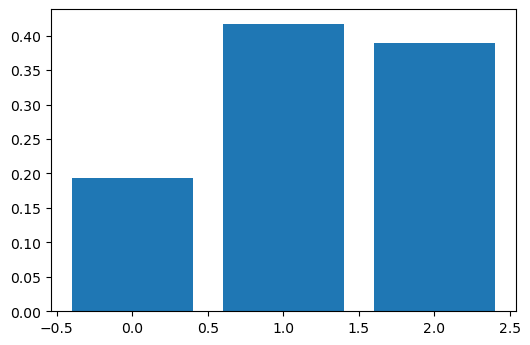

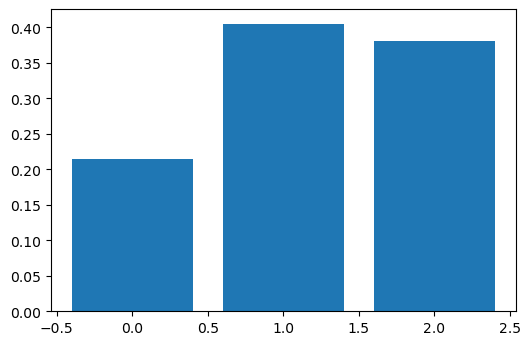

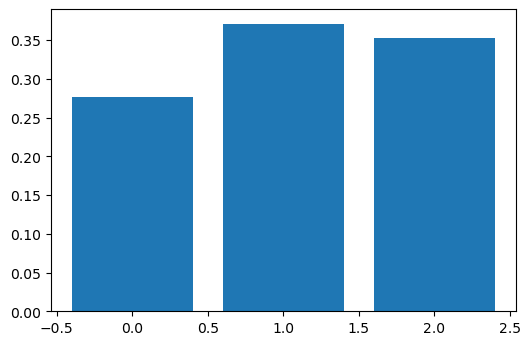

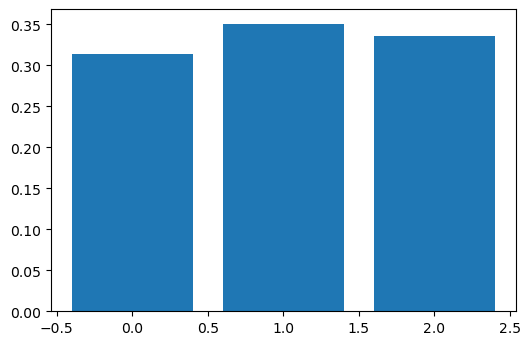

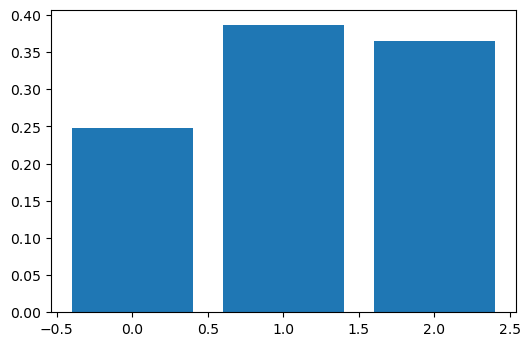

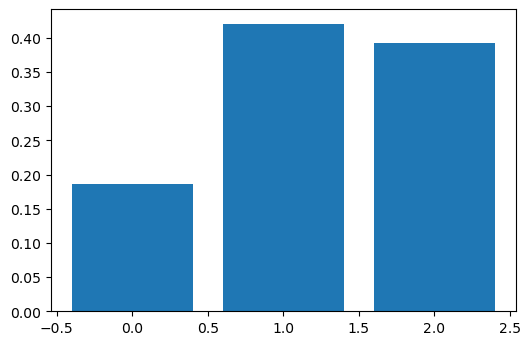

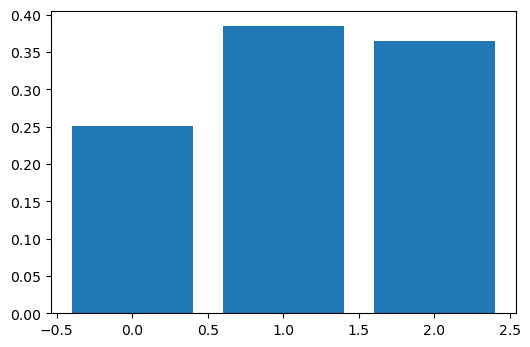

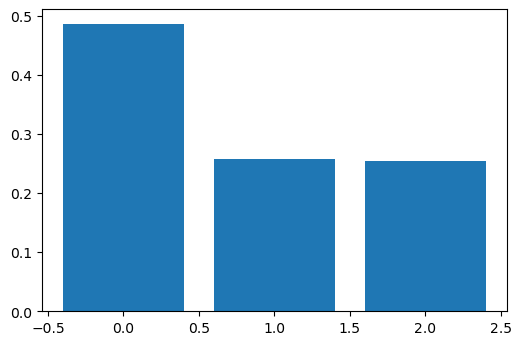

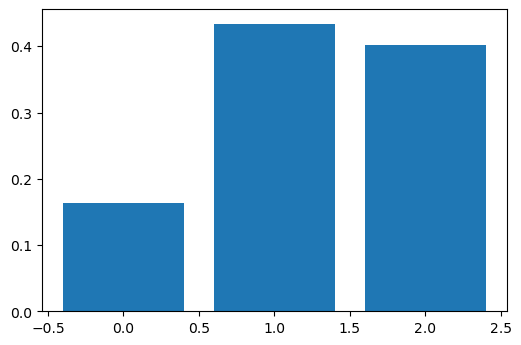

In [75]:
for preds in predictions:
    plt.bar([0,1,2], preds)
    plt.show()

In [95]:
print(np.argmax(predictions, axis=-1))
print(y_exclude)

[1 2 2 1 2 1 2 2 0 2]
[1 2 2 1 2 1 2 1 0 2]
